In [1]:
import geopandas as gpd
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# load in geojson files

gdf_ar = gpd.read_file('../data/alt/gis/point/ar_samples_full.geojson')

gdf_cnty = gpd.read_file('../data/alt/gis/polygon/county.geojson')



In [5]:
# function to print the name and crs for each geodataframe above

def print_crs():
    print('county crs:', gdf_cnty.crs)
    print('sample data crs:', gdf_ar.crs)

print_crs()

county crs: EPSG:4269
sample data crs: EPSG:4269


# Feature Engineering

Convert elevated arsenic, bedrock type, geologic belt, well depth into dummy variables for modeling. Check for interaction of belt and rock type to guage need for interaction - newly engineered crosstab variables

In [6]:
# Check category levels reflect original study
gdf_ar['belt2'].value_counts()

belt2
Kings Mountain Belt    746
Charlotte Belt         668
Inner Piedmont         269
Name: count, dtype: int64

In [7]:
gdf_ar['type'].value_counts()

type
Intrusive Rocks      990
Metamorphic Rocks    693
Name: count, dtype: int64

In [8]:
# cross tabulate belt2 and type

pd.crosstab(gdf_ar['belt2'], gdf_ar['type'])

type,Intrusive Rocks,Metamorphic Rocks
belt2,,
Charlotte Belt,559,109
Inner Piedmont,79,190
Kings Mountain Belt,352,394


In [9]:
# cross tabulate belt2, type, and geocode to check exclusivity

pd.crosstab([gdf_ar['belt2'], gdf_ar['type']], gdf_ar['geocode'])

geocode                                CZab  CZbg  CZbl  CZfv  CZg  CZms  DOg   
belt2               type                                                        
Charlotte Belt      Intrusive Rocks       0     0     0     0   68     0   88  \
                    Metamorphic Rocks     0     0     0   109    0     0    0   
Inner Piedmont      Intrusive Rocks       0     0     0     0    0     0    0   
                    Metamorphic Rocks    14     6     0     0    0   170    0   
Kings Mountain Belt Intrusive Rocks       0     0     0     0    0     0    0   
                    Metamorphic Rocks     0     0   113     0    0     0    0   

geocode                                Mc  OCg  PPmg  PzZq  Zbt  
belt2               type                                         
Charlotte Belt      Intrusive Rocks     0    0     0   403    0  
                    Metamorphic Rocks   0    0     0     0    0  
Inner Piedmont      Intrusive Rocks    73    6     0     0    0  
                    Metamorphic Rocks   0    0     0     0    0  
Kings Mountain Belt Intrusive Rocks    11    0   310    31    0  
                    Metamorphic Rocks   0    0     0     0  281


Simplify belt and rock type values

In [10]:
# Simplify belt and rock type values
# for belt2, Charlotte Belt = CB, "Inner Piedmont" = IP, "Kings Mountain Belt" = KM
# for type Intrusive Rocks = IR, Metamorphic Rocks = MR

gdf_ar['belt2'] = gdf_ar['belt2'].replace(['Charlotte Belt', 'Inner Piedmont', 'Kings Mountain Belt'], ['CB', 'IP', 'KM'])
gdf_ar['type'] = gdf_ar['type'].replace(['Intrusive Rocks', 'Metamorphic Rocks'], ['IR', 'MR'])



Crossing belt with rock type would result in 6 columns, whereas the formation code provides more granularity with 12 columns

In [11]:
# create new variable combining belt and rock type

gdf_ar['belt_type'] = gdf_ar['belt2'] + '_' + gdf_ar['type']

gdf_ar['belt_type'].value_counts()

belt_type
CB_IR    559
KM_MR    394
KM_IR    352
IP_MR    190
CB_MR    109
IP_IR     79
Name: count, dtype: int64

In [12]:
# create dummy variables for belt_type, depth_cat, and group

#gdf_ar = pd.get_dummies(gdf_ar, columns=['belt_type', 'depth_cat', 'landuse'])

# use line above when well depth data is complete

gdf_ar = pd.get_dummies(gdf_ar, columns=['belt_type', 'landuse'])

## Assess Correlation

In [13]:
# create a correlation matrix with group_five as the dependent variable
# and all other numeric data as independent variables

In [14]:
gdf_ar.columns

Index(['id', 'full_add', 'date_tested', 'year_tested', 'ar', 'group',
       'group_five', 'group_mcl', 'ph', 'sample_id', 'geocode', 'belt2',
       'type', 'num_mines_250', 'num_mines_500', 'num_mines_1k',
       'num_mines_2k', 'dist_to_mine', 'dist_crops', 'dist_fault', 'geometry',
       'belt_type_CB_IR', 'belt_type_CB_MR', 'belt_type_IP_IR',
       'belt_type_IP_MR', 'belt_type_KM_IR', 'belt_type_KM_MR',
       'landuse_Developed', 'landuse_Forest', 'landuse_Other',
       'landuse_Pasture'],
      dtype='object')

In [16]:
cr = pd.DataFrame(gdf_ar.drop(['id', 'full_add',  'date_tested', 'sample_id',
       'year_tested', 'belt2','type','geometry','geocode'], axis=1))

In [17]:
cr.columns

Index(['ar', 'group', 'group_five', 'group_mcl', 'ph', 'num_mines_250',
       'num_mines_500', 'num_mines_1k', 'num_mines_2k', 'dist_to_mine',
       'dist_crops', 'dist_fault', 'belt_type_CB_IR', 'belt_type_CB_MR',
       'belt_type_IP_IR', 'belt_type_IP_MR', 'belt_type_KM_IR',
       'belt_type_KM_MR', 'landuse_Developed', 'landuse_Forest',
       'landuse_Other', 'landuse_Pasture'],
      dtype='object')

In [20]:
len(cr)

1683

In [18]:
# scan data frame and convert boolean columns to binary

for col in cr.columns:
    if cr[col].dtype == 'bool':
        cr[col] = cr[col].astype('int')



<Axes: >

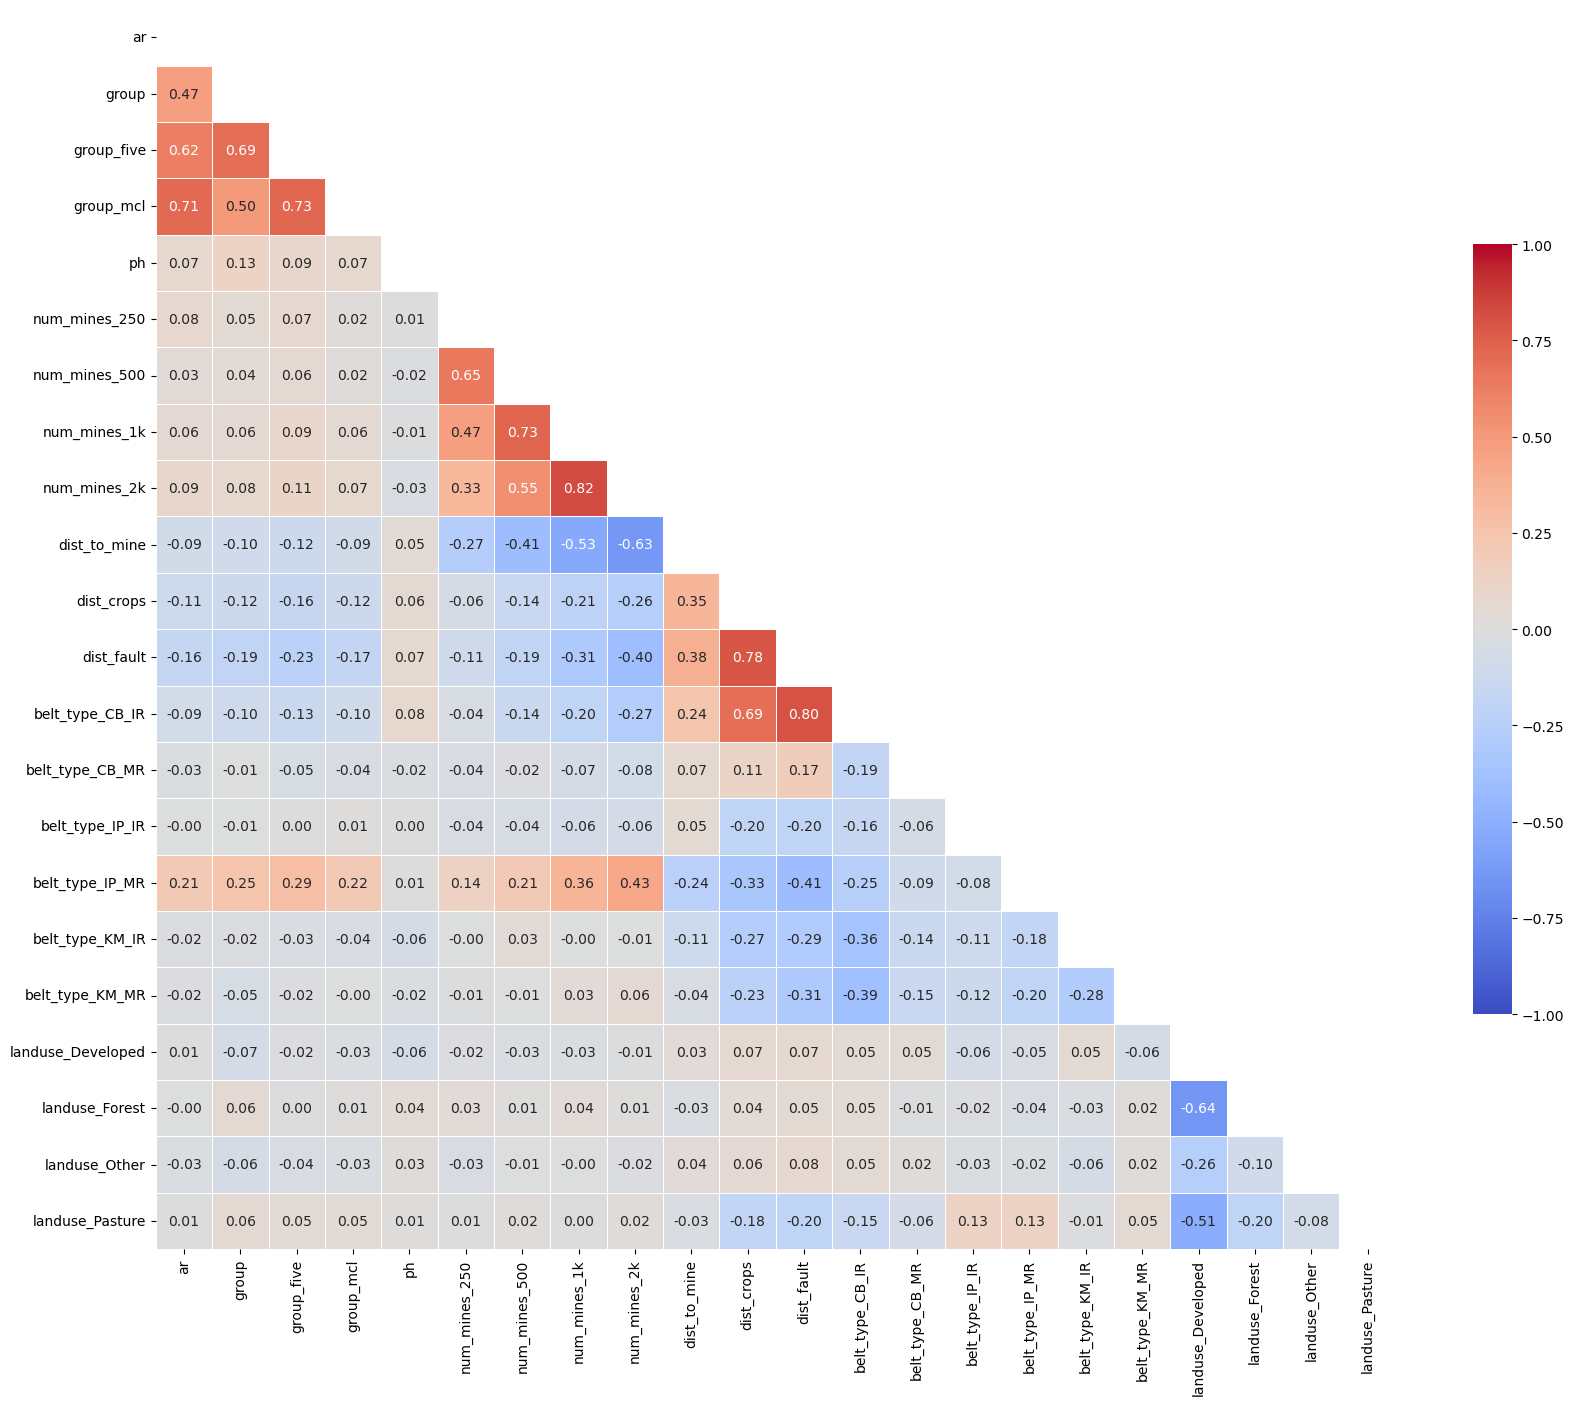

In [19]:
plt.figure(figsize=(20,20))
# creating mask
mask = np.triu(np.ones_like(cr.corr()))
sns.heatmap(cr.corr()
            , cmap='coolwarm'
            , annot=True
            , fmt='.2f'
            , vmin=-1
            , vmax=1
            , center=0
            , square=True
            , linewidths=0.5
            , cbar_kws={"shrink": 0.5},
              mask=mask)